In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 10)
import pyqg
import pyqg.diagnostic_tools
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%%time
year = 24*60*60*360.
base_kwargs = dict(dt=3600., tmax=5*year, tavestart=2.5*year, twrite=25000)

low_res = pyqg.QGModel(nx=64, **base_kwargs)
low_res.run()

INFO:  Logger initialized
INFO: Step: 25000, Time: 9.00e+07, KE: 3.93e-04, CFL: 0.051


CPU times: user 21.8 s, sys: 235 ms, total: 22 s
Wall time: 22.2 s


In [3]:
%%time
high_res = pyqg.QGModel(nx=256, **base_kwargs)
high_res.run()

INFO:  Logger initialized
INFO: Step: 25000, Time: 9.00e+07, KE: 5.16e-04, CFL: 0.198


CPU times: user 12min 8s, sys: 12.2 s, total: 12min 20s
Wall time: 6min 40s


In [4]:
def run_parameterized_model(p):
    model = pyqg.QGModel(nx=64, parameterization=p, **base_kwargs)
    model.run()
    return model

In [5]:
%%time
smagorinsky = run_parameterized_model(
    pyqg.parameterizations.Smagorinsky(constant=0.08))

INFO:  Logger initialized
INFO: Step: 25000, Time: 9.00e+07, KE: 3.62e-04, CFL: 0.036


CPU times: user 1min, sys: 2.1 s, total: 1min 2s
Wall time: 1min 3s


In [6]:
%%time
backscatter = run_parameterized_model(
    pyqg.parameterizations.BackscatterBiharmonic(smag_constant=0.08, back_constant=1.1))

INFO:  Logger initialized
INFO: Step: 25000, Time: 9.00e+07, KE: 4.32e-04, CFL: 0.044


CPU times: user 56.2 s, sys: 1.77 s, total: 58 s
Wall time: 58.4 s


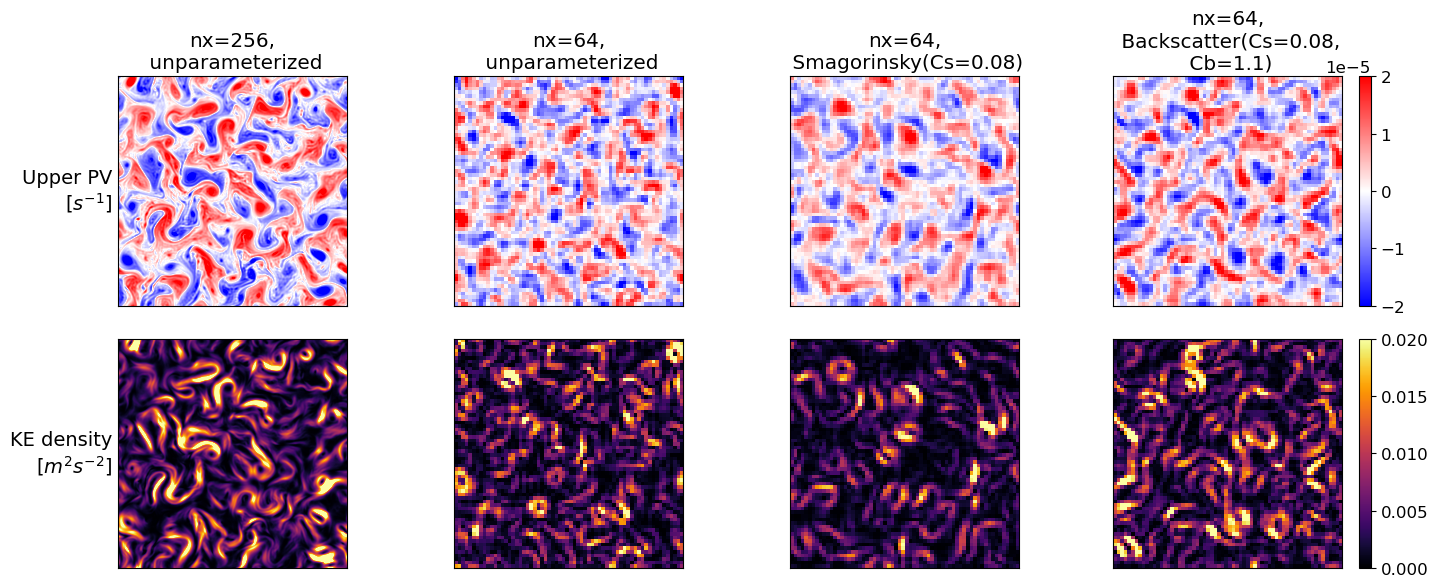

In [7]:
def label_for(sim):
    return f"nx={sim.nx}, {sim.parameterization or 'unparameterized'}"

plt.figure(figsize=(15,6))
plt.rcParams.update({'font.size': 12})
vlim = 2e-5
for i, sim in enumerate([high_res, low_res, smagorinsky, backscatter]):
    plt.subplot(2, 4, i+1, title=label_for(sim).replace(',',",\n").replace('Biharmonic',''))
    plt.imshow(sim.q[0], vmin=-vlim, vmax=vlim, cmap='bwr')
    plt.xticks([]); plt.yticks([])
    if i == 0: plt.ylabel("Upper PV\n[$s^{-1}$]", rotation=0, va='center', ha='right', fontsize=14)
    if i == 3: plt.colorbar()

vlim = 2e-2
for i, sim in enumerate([high_res, low_res, smagorinsky, backscatter]):
    plt.subplot(2, 4, i+5)
    plt.imshow((sim.u**2 + sim.v**2).sum(0), vmin=0, vmax=vlim, cmap='inferno')
    plt.xticks([]); plt.yticks([])
    if i == 0: plt.ylabel("KE density\n[$m^2 s^{-2}$]", rotation=0, va='center', ha='right', fontsize=14)
    if i == 3: plt.colorbar()

plt.tight_layout()

In [8]:
sims = [high_res, backscatter, low_res, smagorinsky]

pd.DataFrame.from_dict([
    dict(Simulation=label_for(sim),
        **pyqg.diagnostic_tools.diagnostic_similarities(sim, high_res, low_res))
    for sim in sims])

,Simulation,Ensspec1,Ensspec2,KEspec1,KEspec2,...,ENSfrictionspec,APEgenspec,APEflux,KEflux,APEgen
0,"nx=256, unparameterized",1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000
1,"nx=64, BackscatterBiharmonic(Cs=0.08, Cb=1.1)",0.499746,0.479806,0.549319,0.554305,...,0.385181,0.659339,0.356870,0.348028,0.793576
2,"nx=64, unparameterized",0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000
3,"nx=64, Smagorinsky(Cs=0.08)",-0.001108,0.363670,-0.095423,-0.162433,...,-0.099888,0.059415,-0.065146,-0.176532,0.109986


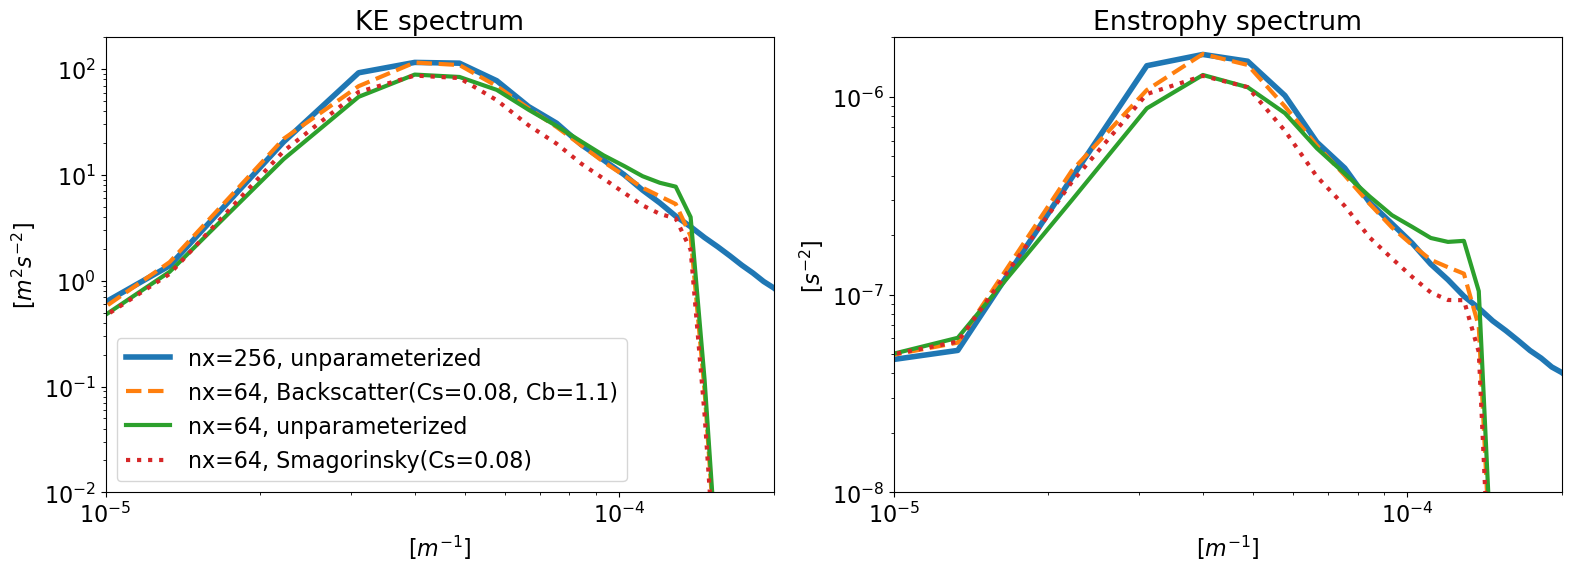

In [9]:
def plot_kwargs_for(sim):
    kw = dict(label=label_for(sim).replace('Biharmonic',''))
    kw['ls'] = (':' if sim.uv_parameterization else ('--' if sim.q_parameterization else '-'))
    kw['lw'] = (4 if sim.nx==256 else 3)
    return kw

plt.figure(figsize=(16,6))
plt.rcParams.update({'font.size': 16})

plt.subplot(121, title="KE spectrum")
for sim in sims:
    plt.loglog(
        *pyqg.diagnostic_tools.calc_ispec(sim, sim.get_diagnostic('KEspec').sum(0)),
        **plot_kwargs_for(sim))
plt.ylabel("[$m^2 s^{-2}$]")
plt.xlabel("[$m^{-1}$]")
plt.ylim(1e-2,2e2)
plt.xlim(1e-5, 2e-4)
plt.legend(loc='lower left')

plt.subplot(122, title="Enstrophy spectrum")
for sim in sims:
    plt.loglog(
        *pyqg.diagnostic_tools.calc_ispec(sim, sim.get_diagnostic('Ensspec').sum(0)),
        **plot_kwargs_for(sim))
plt.ylabel("[$s^{-2}$]")
plt.xlabel("[$m^{-1}$]")
plt.ylim(1e-8,2e-6)
plt.xlim(1e-5, 2e-4)
plt.tight_layout()